In [ ]:
!pip install sox==1.4.1
!pip install PySoundFile==0.9.0.post1

In [1]:
import os
import glob
import yaml
import time
import random
import pathlib
from IPython.display import Audio

import tqdm
import librosa
import numpy as np
import pandas as pd

import torch
import torchaudio
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('seaborn')

import utils

In [2]:
try:
    with open('config.yml', 'r') as stream:
        config = yaml.safe_load(stream)
except FileNotFoundError:
    with open('config.yaml', 'r') as stream:
        config = yaml.safe_load(stream)

In [3]:
wave_transforms = [
    utils.augmentation.wave.RIR(config['sample_rate'], p=0.5),
    # utils.augmentation.wave.LPHPFilter(config['sample_rate'], p=1),
    utils.augmentation.wave.TimeShift(None, p=0.5),
    utils.augmentation.wave.AdditiveUN(min_snr_db=30, max_snr_db=1, p=0.5)
]

spec_transforms = [
    utils.augmentation.spec.DropBlock2D(0.5, [16, 4]),
    utils.augmentation.spec.TimeMasking(20, 6, 0.5),
    utils.augmentation.spec.FrequencyMasking(5, 5, 0.5),
]

In [4]:
esc_dataset = utils.datasets.ESCDataset(
    audio_length=5,
    folds=[1, 2, 3],
    wave_transforms=wave_transforms,
    spec_transforms=spec_transforms,
)

In [5]:
urban_dataset = utils.datasets.UrbanDataset(
    audio_length=5,
    folds=[1, 2, 3],
    wave_transforms=wave_transforms,
    spec_transforms=spec_transforms,
)

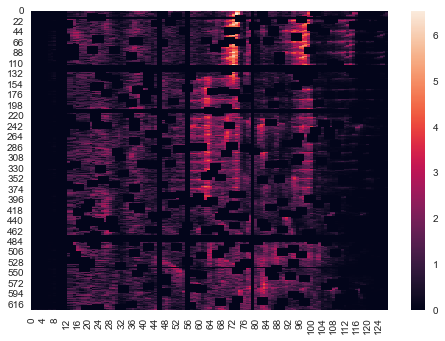

In [8]:
train_loader =  torch.utils.data.DataLoader(
    esc_dataset, 
    batch_size=2,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    shuffle=False,
    collate_fn=esc_dataset.collate_fn
)

for batch in train_loader:
    x, wave, y = batch
    break
    
sns.heatmap(
    x[1, 0]
)

Audio(wave[1], rate=config['sample_rate'])

In [9]:
class SwiGLU(nn.Module):
    """https://arxiv.org/abs/2002.05202"""
    def forward(self, x:torch.Tensor):
        # |x| : (..., Any)
        x, gate = x.chunk(2, dim=-1)
        x = F.silu(gate) * x
        # |x| : (..., Any//2)
        return x

In [10]:
act = SwiGLU()

In [12]:
x.shape

torch.Size([2, 1, 627, 128])

In [14]:
act(x).shape

torch.Size([2, 1, 627, 64])

In [61]:
class ResBlock(nn.Module):
    activation = {
        'gelu': nn.GELU,
        'lrelu': nn.LeakyReLU,
        ''
    }
    def __init__(self, c_in: int, c_emb: int, c_out: int, 
            kernel_size: tuple[int, int] = [5, 5], 
            kernel_size_res: tuple[int, int] = [2, 2]):
        super(ResBlock, self).__init__()
        
        dilation = [2 - kernel_size[0]%2, 2 - kernel_size[0]%2]
        dilation_res = [2 - kernel_size_res[0]%2, 2 - kernel_size_res[0]%2]
        
        self.batchnorm_1 = nn.BatchNorm2d(c_in)
        self.batchnorm_2 = nn.BatchNorm2d(c_emb)
        
        self.conv1 = nn.Conv2d(c_in, c_emb, kernel_size, dilation=dilation, padding='same')
        self.conv2 = nn.Conv2d(c_emb, c_out, kernel_size, dilation=dilation, padding='same')
        self.conv_res = nn.Conv2d(c_in, c_out, kernel_size_res, dilation=dilation_res, padding='same')
            
        self.act = nn.GELU()
        
    def forward(self, x):
        # |x| : (batch_size, C, H, W)
        res = self.conv_res(x)
        
        # ------------------------- #
        if True:
            x = self.batchnorm_1(x)
            x = self.act(x)
        else:
            x = self.act(x)
            x = self.batchnorm_1(x)
        x = self.conv1(x)
    
        # ------------------------- #
        if True:
            x = self.batchnorm_2(x)
            x = self.act(x)
        else:
            x = self.act(x)
            x = self.batchnorm_2(x)
        x = self.conv2(x)
        
        return x + res

In [62]:
res_block = ResBlock(1, 8, 16)

In [63]:
torchsummary.summary(res_block);

Layer (type:depth-idx)                   Param #
├─BatchNorm2d: 1-1                       2
├─BatchNorm2d: 1-2                       16
├─Conv2d: 1-3                            208
├─Conv2d: 1-4                            3,216
├─Conv2d: 1-5                            80
Total params: 3,522
Trainable params: 3,522
Non-trainable params: 0


In [64]:
res_block

ResBlock(
  (batchnorm_1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv_res): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=same, dilation=(2, 2))
)

In [65]:
res_block(x).shape

torch.Size([2, 16, 128, 627])

In [20]:
class Model(nn.Module):
    def __init__(self, input_shape: tuple[int, int]):
        super(Model, self).__init__()

        self.input_shape = input_shape
        
        

In [27]:
nn.BatchNorm2d(1)(x)

tensor([[[[-0.3606, -0.3606, -0.3606,  ..., -0.3605, -0.3605, -0.3605],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          ...,
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606]]],


        [[[-0.3606, -0.3604, -0.3604,  ..., -0.3602, -0.3605, -0.3480],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3606],
          ...,
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3605],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3605],
          [-0.3606, -0.3606, -0.3606,  ..., -0.3606, -0.3606, -0.3605]]]],
       grad_fn=<NativeBatchNormBackward0>)

In [22]:
x

tensor([[[[1.0716e-06, 4.4293e-06, 3.4292e-06,  ..., 9.0223e-05,
           6.9651e-05, 7.3723e-05],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]],


        [[[1.3788e-05, 1.2708e-04, 1.2187e-04,  ..., 2.4385e-04,
           5.9007e-05, 7.6253e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.4288e-07, 1.4288e-07, 7.1441e-08,  ..., 0.00